 REF: https://www.confident-ai.com/blog/llm-evaluation-metrics-everything-you-need-for-llm-evaluation#what-are-llm-evaluation-metrics-

# Statistical Scorers

## 1. Perplexity

Perplexity is a key metric used to evaluate how well a language model predicts a sequence of words. Importantly, it does **not** require ground truth!

### What is Perplexity?

- **Perplexity** measures how "perplexed" or "confused" a model is when predicting the next word in a sequence.
- A **lower perplexity** means the model is less confused and does a better job at predicting the next word.
- A **higher perplexity** indicates more confusion, meaning the model struggles to predict the next word accurately.

### Examples:
1. **Perplexity = 1**: The model perfectly predicted the sequence with 100% accuracy.
2. **Perplexity = 10**: The model is equally uncertain about 10 options for the next word, indicating confusion.

---

### Example: Perplexity Calculation

**Assume the LLM predicted “The Hat is on the mat.” for some prompt.**

#### **Step 1: Calculate the probabilities for each word given the previous words.**
For example, we have the following probabilities:

- P(“The”) = 0.5
- P(“hat” | “The”) = 0.4
- P(“is” | “The hat”) = 0.3
- P(“on” | “The hat is”) = 0.4
- P(“the” | “The hat is on”) = 0.5
- P(“mat” | “The hat is on the”) = 0.6

#### **Step 2: Apply log and sum the probabilities:**

```text
log(P(“The”)) +
log(P(“hat” | “The”)) +
log(P(“is” | “The hat”)) +
log(P(“on” | “The hat is”)) +
log(P(“the” | “The hat is on”)) +
log(P(“mat” | “The hat is on the”)) = abc
```
#### **Step 3: Average the log values and apply exponential:**

```text
exp(abc / 6) = 2.275 (Assumed value)

```

Hence, the Perplexity = 2.275, meaning the model had to choose from about 2.275 possible words for the next word in the sequence.


## Notes:

### Perplexity Calculation:
To calculate perplexity, you need the probabilities of the predictions. This means perplexity isn't useful when using APIs like OpenAI or Anthropic, where probability scores aren't accessible. For HuggingFace-loaded models, you can use the evaluate package to calculate perplexity by following the code below and changing the model's name.

### Text Length Limitations in Models:
- When using models like GPT-2, there's a limit to how much text the model can handle at once (e.g., 1024 tokens).
- If the text is longer, we need to split it into smaller chunks.

### Suboptimal Method:
- A quick but less accurate approach is to calculate the model's predictions for each chunk separately. However, this method doesn't allow the model to consider the full context, resulting in worse performance.

### Better Method: Sliding Window Approach
- The sliding window method allows the model to process overlapping parts of the text. This approach gives the model more context, leading to better predictions. However, it can be time-consuming since the window must be moved step by step.

### Strided Sliding Window:
- To speed things up, a strided sliding window can be used. This method moves the context window by larger steps, allowing faster computation while still giving the model enough context to make better predictions.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (e.g., GPT-2)
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Assign the EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:

def calculate_batch_perplexity(input_texts):
    """
    Calculate perplexity for a batch of input texts using a pretrained language model.

    Args:
    - input_texts (List[str]): A list of input texts to evaluate.

    Returns:
    - List[float]: A list of perplexity scores, one for each input text.
    """
    # Tokenize the batch of texts with padding for uniform length
    inputs = tokenizer(
        input_texts, return_tensors="pt", padding=True, truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Pass the input batch through the model to get logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids to align targets correctly
    # Logits dimensions are: (batch_size, seq_length, vocab_size)
    shift_logits = logits[:, :-1, :]  # Ignore the last token's logits
    shift_labels = input_ids[:, 1:]   # Skip the first token in the labels

    # Compute log probabilities
    log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)

    # Gather the log probabilities for the correct tokens
    target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask out positions corresponding to padding tokens
    target_log_probs = target_log_probs * attention_mask[:, 1:].to(log_probs.dtype)

    # Compute the mean negative log-likelihood for each sequence
    negative_log_likelihood = -target_log_probs.sum(dim=-1) / attention_mask[:, 1:].sum(dim=-1)

    # Compute perplexity for each sequence
    perplexities = torch.exp(negative_log_likelihood)
    perplexities = perplexities

    # Take mean of perplexities of each batch
    mean_perplexity_score = torch.mean(perplexities)

    return {"perplexities": perplexities, "mean_perplexity": mean_perplexity_score}

In [ ]:
texts = [
    "This library will download and cache datasets and metrics processing scripts and data locally.",
    "A journey of a thousand miles begins with a single step."
]
print(f"Perplexity scores: {calculate_batch_perplexity(texts)}")

Perplexity scores: {'perplexities': tensor([230.9339,  30.0616]), 'mean_perplexity': tensor(130.4978)}


## 2. BLEU Metric

The BLEU (BiLingual Evaluation Understudy) metric is widely used in machine translation tasks to evaluate the quality of text generated by models like GPT-2. It compares the machine-generated translation with one or more reference translations to determine how "good" the generated text is.




### How BLEU Works

#### N-grams Comparison
- **BLEU** compares the **n-grams** (chunks of n words) between the generated translation and reference translations.
  - **Unigrams**: Individual words in a sentence.
  - Higher-order **n-grams** (e.g., bigrams, trigrams, etc.) can also be compared to consider context and word order.

#### Precision Calculation
- BLEU calculates **precision** for matching n-grams between the generated text and reference translations:
  - **Unigram precision**: For example, if there are 5 words in the generated text and 4 match a reference, the unigram precision is calculated as:
    - \( \frac{4}{5} = 0.8 \)
  - **Higher-order n-gram precision**: Similar calculations are done for **bigrams**, **trigrams**, and **4-grams**.

#### Modified Precision
- BLEU uses **modified precision** to handle issues such as **word repetition** in the generated translation:
  - Words are **clipped** based on the maximum number of times they appear in the reference.
  - Example: If a word appears twice in the reference, the count of that word in the generated text is limited to two.

#### Averaging Precision Scores
- BLEU computes precision for multiple n-grams and averages them.
  - For example, **BLEU-4** reports the average precision of **unigrams**, **bigrams**, **trigrams**, and **4-grams**.

#### Geometric Mean
- The final **BLEU score** is the **geometric mean** of the individual n-gram precision scores. This helps combine the precision across different n-gram sizes into a single number representing translation quality.

### Limitations of BLEU

- **Lack of Semantics**: BLEU only focuses on surface-level word matching and doesn’t account for the meaning of the words.
- **Word Order Problems**: BLEU can give high precision for incorrect word order (e.g., Yoda-like translations).
- **Non-English Languages**: BLEU struggles with languages that have different structures from English.
- **Tokenization Issues**: BLEU assumes that reference translations are already tokenized, which may create problems when comparing models that use different tokenizers.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
import evaluate
bleu = evaluate.load("bleu")

In [ ]:
# Example 1: Perfect Match
predictions = ["the quick brown fox jumps over", "a lazy dog"]
references = [
    ["the quick brown fox jumps over"],
    ["a lazy dog"]
]
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 9, 'reference_length': 9}


In [ ]:
# Example 2: Partial Match
predictions = ["the quick brown fox jumps", "a dog"]
references = [
    ["the quick brown fox leaps over"],
    ["a sleepy dog"]
]
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 0.48354474047437324, 'precisions': [0.8571428571428571, 0.6, 0.6666666666666666, 0.5], 'brevity_penalty': 0.751477293075286, 'length_ratio': 0.7777777777777778, 'translation_length': 7, 'reference_length': 9}


In [ ]:
# Example 3: No Match

predictions = ["good morning", "hello world"]
references = [
    ["the fast brown fox leaps over"],
    ["a sleepy dog"]
]
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)


{'bleu': 0.0, 'precisions': [0.0, 0.0, 0.0, 0.0], 'brevity_penalty': 0.2865047968601901, 'length_ratio': 0.4444444444444444, 'translation_length': 4, 'reference_length': 9}


The brevity penalty is a factor applied to the final BLEU score to penalize translations that are shorter than the reference translations. The idea is that if a machine translation generates a much shorter output than the reference, it may have missed some important parts of the meaning. This is particularly useful in cases where a translation system generates very short sentences that aren't fully aligned with the reference in terms of content.

## 3.  ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

### 3.1. ROUGE-N Metric

ROUGE-N measures the number of matching n-grams between the model-generated text and a human-produced reference.

Consider the reference R and the candidate summary C:

* R: The hat is on the mat.
* C: The hat and the cat.

##### 3.1.1 ROUGE-1

Using **R** and **C**, we are going to compute the `precision`, `recall`, and `F1-score` of the matching `n-grams`. Let’s start computing ROUGE-1 by considering 1-grams only.

* ROUGE-1 ***precision*** can be computed as `the ratio of the number of unigrams in C that appear also in R (that are the words “the”, “hat, and “the”), over the number of unigrams in C.`
  
  ```text
  ROUGE-1 precision = 3/5 = 0.6
  ```

* ROUGE-1 ***recall*** can be computed as `the ratio of the number of unigrams in R that appear also in C (that are the words “the”, hat, and “the”), over the number of unigrams in R.`

  ```text
  ROUGE-1 recall = 3/6 = 0.5
  ```

* Then, ROUGE-1 F1-score can be directly obtained from the ROUGE-1 precision and recall using the standard F1-score formula.

  ```text
  ROUGE-1 F1-score = 2 * (precision * recall) / (precision + recall) = 0.54
  ```

##### 3.1.2 ROUGE-2
Let’s try computing the ROUGE-2 considering 2-grams.

Remember our reference R and candidate summary C:

* R: The hat is on the mat.
* C: The hat and the cat.

* ROUGE-2 ***precision*** is the ratio of the `number of 2-grams in C that appear also in R (only the 2-gram “the hat”), over the number of 2-grams in C.`

  ```text
  ROUGE-2 precision = 1/4 = 0.25
  ```

* ROUGE-2 ***recall*** is the ratio of the `number of 2-grams in R that appear also in C (only the 2-gram “the hat”), over the number of 2-grams in R.`

  ```text
  ROUGE-2 recall = 1/5 = 0.20
  ```
* Therefore, the F1-score is:

  ```text
  ROUGE-2 F1-score = 2 * (precision * recall) / (precision + recall) = 0.22
  ```

In [ ]:
!pip install evaluate
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=0ed7dec16c922888d0c941e1e29bab8233511b11df3d91a79359314982cae65e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


### 3.2. Rouge-L Metric

**ROUGE-L** is based on the longest common subsequence (LCS) between our model output and reference, i.e. the longest sequence of words (not necessarily consecutive, but still in order) that is shared between both. A longer shared sequence should indicate more similarity between the two sequences.

We can compute ROUGE-L recall, precision, and F1-score just like we did with ROUGE-N, but this time we replace each n-gram match with the LCS.

Remember our reference R and candidate summary C:

* R: The hat is on the mat.
* C: The hat and the cat.

The LCS is the 3-gram `“the hat the”` (remember that the words are not necessarily consecutive), which appears in both R and C.

* ROUGE-L precision is the ratio of the length of the LCS, over the number of unigrams in C.

  ```text
  ROUGE-L precision = 3/5 = 0.6
  ```

* ROUGE-L precision is the ratio of the length of the LCS, over the number of unigrams in R.
  ```text
  ROUGE-L recall = 3/6 = 0.5
  ```
Therefore, the F1-score is:
  ```text
  ROUGE-L F1-score = 2 * (precision * recall) / (precision + recall) = 0.55
  ```


In [ ]:
rouge = evaluate.load('rouge')
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
results = rouge.compute(predictions=predictions,references=references,use_aggregator=False)
print(results)

{'rouge1': [1.0, 1.0], 'rouge2': [1.0, 1.0], 'rougeL': [1.0, 1.0], 'rougeLsum': [1.0, 1.0]}


The output is a dictionary with one entry for each rouge type in the input list rouge_types. If `use_aggregator=False`, each dictionary entry is a list of scores, with one score for each sentence.

E.g. if  use_aggregator=False, the output is like above

In [ ]:
import evaluate

rouge = evaluate.load('rouge')

predictions = [
    "Artificial Intelligence is the future",
    "Deep Learning is a subset of Machine Learning",
    "Have a great day!"
]

references = [
    ["AI will revolutionize the world", "The future belongs to Artificial Intelligence"],
    ["Deep Learning is part of AI", "Machine Learning includes Deep Learning"],
    ["Wishing you a wonderful day", "Hope you have an amazing day"]
]

results = rouge.compute(predictions=predictions, references=references,use_aggregator=False)

print(results)


{'rouge1': [0.7272727272727272, 0.6153846153846154, 0.4444444444444445], 'rouge2': [0.4444444444444445, 0.36363636363636365, 0.0], 'rougeL': [0.3636363636363636, 0.5714285714285715, 0.4444444444444445], 'rougeLsum': [0.3636363636363636, 0.5714285714285715, 0.4444444444444445]}


## 4. METEOR (Metric for Evaluation of Translation with Explicit Ordering)

This considers both `precision` and `recall`.

Recall measures how well the candidate translation captures all the words or information in the reference translation.

This dual consideration allows METEOR to provide a more holistic assessment of translation quality.

One of the standout features of the METEOR score is its ability to go beyond exact word matches. It incorporates **stemming**, which reduces words to their root forms (e.g., “running” becomes “run”), and **synonymy**, which recognises synonyms as valid matches. This makes METEOR more robust in handling variations in language use, such as different word forms or alternative phrasing.

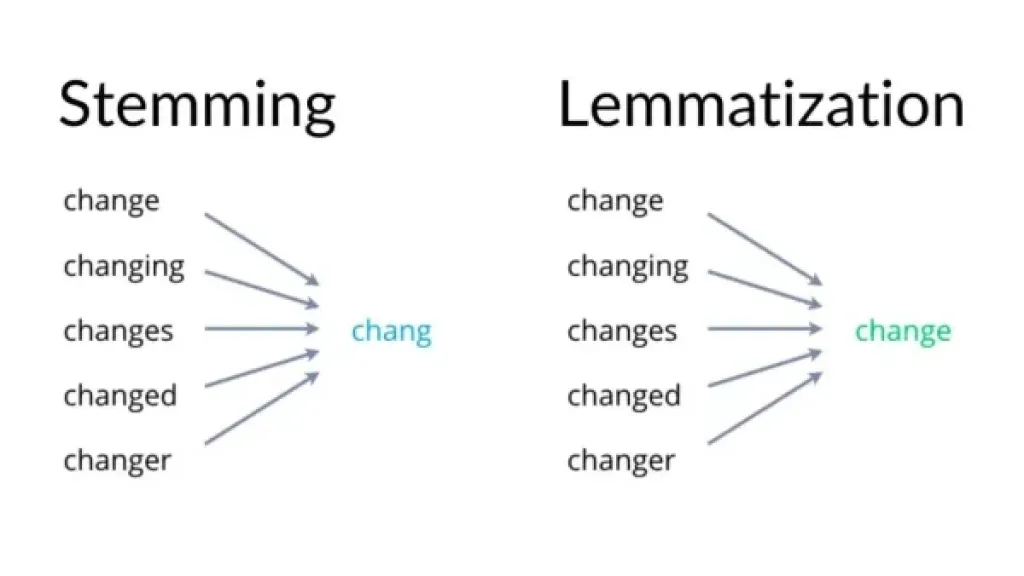

# How METEOR Works (in Simple Terms)

### 1. **Precision and Recall**
- **Precision**: This checks how many words in the translation you created (candidate) match exactly with the "perfect" translation (reference). For example, if your translation says "dog" and the reference says "dog," it's a match.
- **Recall**: This looks at how many words from the perfect translation (reference) are also in your translation (candidate). It checks if you’ve captured all the important words from the reference translation.
- **Why Combine Them?**: Instead of just focusing on how many words are correct or how much of the reference is covered, METEOR combines both. This balance helps it be fairer when evaluating translations.

### 2. **Word Matching Techniques**
METEOR uses different methods to match words between the translation you made (candidate) and the perfect translation (reference):
- **Exact Match**: If you use the exact same word as the reference, it counts as a match. For example, "dog" in both translations is a perfect match.
- **Stemming**: This looks at the base form of words. For example, "running," "ran," and "runs" are all treated as "run." This helps if your translation uses a slightly different form of a word but still has the same meaning.
- **Synonymy**: If your translation uses a synonym (a word with a similar meaning) for a word in the reference, METEOR counts it as a match. For example, "happy" and "joyful" are synonyms, so they count as the same.
- **Paraphrasing**: Sometimes, a translation might say the same thing in a different way (for example, “I’m hungry” vs. “I need food”). Some versions of METEOR can recognize these kinds of paraphrases as valid matches.

### 3. **Word Alignment**
After matching words using the techniques above, METEOR pairs words in your translation with words in the reference translation. It essentially "lines them up" to see how well your translation matches the reference.

### 4. **Precision and Recall Calculation**
Once the words are matched, METEOR calculates two things:
- **Precision**: How many of the words in your translation (candidate) match the reference.
- **Recall**: How many of the words in the reference translation are present in your translation.
These two are combined into a single score using a special math formula called the "harmonic mean," which gives a fair balance between the two.

### 5. **Penalty Functions**
METEOR also uses penalties to make sure your translation isn't just a simple list of matched words:
- **Fragmentation Penalty**: If the matching words are spread out and not in a logical order, METEOR will lower your score. This penalty discourages translations that seem disorganized or fragmented.
- **Ordering Penalty**: If the words in your translation are in a different order than the reference, METEOR will also apply a penalty. This ensures that your translation doesn’t just use the right words but also places them in a natural and fluent order.

### 6. **Final METEOR Score**
The final METEOR score is a single number that takes into account:
- The balance between how many words match (precision) and how much of the reference is captured (recall).
- Any penalties for things like fragmented words or wrong word order.
This final score tells you how accurate and fluent your translation is compared to the reference.


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import evaluate
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# with single reference
predictions = "A small dog quickly ran across the park."
reference = "The tiny dog ran fast through the park."
results = meteor.compute(predictions=[predictions], references=[reference])
print(results)

{'meteor': 0.4955555555555556}


In [ ]:
# with multiple references
meteor = evaluate.load('meteor')
predictions = ["The quick brown fox jumps over the lazy dog"]
references = [['A fast brown fox leaps over a lazy dog',
              'The quick brown fox jumps over the lazy dog']]
results = meteor.compute(predictions=predictions, references=references)
print(round(results['meteor'], 2))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


1.0


## 5. Levenshtein distance

 This scorer calculates the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word or text string into another, which can be useful for evaluating spelling corrections, or other tasks where the precise alignment of characters is critical.

In [ ]:
%pip install --upgrade --quiet  rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.8 MB/s eta 0:00:00


In [ ]:
from langchain.evaluation import load_evaluator

evaluator = load_evaluator("string_distance")

In [ ]:
evaluator.evaluate_strings(
    prediction="The job is completely done.",
    reference="The job is done",
)

{'score': 0.11555555555555552}

In [ ]:
# The results purely character-based, so it's less useful when negation is concerned
evaluator.evaluate_strings(
    prediction="The job is done.",
    reference="The job isn't done",
)

{'score': 0.0724999999999999}